### Pedro Daia Cardoso

Exercício de treinamento, modelo para distinguir entre a raca de diferentes animais

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

     |████████████████████████████████| 719 kB 7.6 MB/s 
     |████████████████████████████████| 1.2 MB 51.6 MB/s 
     |████████████████████████████████| 4.4 MB 47.6 MB/s 
     |████████████████████████████████| 365 kB 69.0 MB/s 
     |████████████████████████████████| 212 kB 50.1 MB/s 
     |████████████████████████████████| 1.1 MB 64.1 MB/s 
     |████████████████████████████████| 101 kB 9.3 MB/s 
     |████████████████████████████████| 140 kB 56.5 MB/s 
     |████████████████████████████████| 596 kB 28.3 MB/s 
     |████████████████████████████████| 127 kB 64.8 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 271 kB 57.2 MB/s 
     |████████████████████████████████| 144 kB 58.9 MB/s 
     |████████████████████████████████| 6.6 MB 35.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.

In [2]:
path = untar_data(URLs.PETS)
Path.BASE_PATH = path
#path.ls()
(path/"images").ls()

(#7393) [Path('images/Abyssinian_114.jpg'),Path('images/Abyssinian_126.jpg'),Path('images/basset_hound_61.jpg'),Path('images/Sphynx_21.jpg'),Path('images/great_pyrenees_44.jpg'),Path('images/basset_hound_111.jpg'),Path('images/Bengal_165.jpg'),Path('images/havanese_15.jpg'),Path('images/Abyssinian_224.jpg'),Path('images/staffordshire_bull_terrier_19.jpg')...]

output:

```
(#2) [Path('images'),Path('annotations')]

(#7393) [Path('images/Maine_Coon_182.jpg'),Path('images/wheaten_terrier_57.jpg'),Path('images/leonberger_177.jpg'),Path('images/Egyptian_Mau_109.jpg'),Path('images/english_cocker_spaniel_52.jpg'),Path('images/Ragdoll_163.jpg'),Path('images/newfoundland_191.jpg'),Path('images/boxer_12.jpg'),Path('images/beagle_86.jpg'),Path('images/pomeranian_126.jpg')...]
```



Temos essa lista de imagens, precisamos extrair os nomes das racas, para isso vamos focar em utilizar Regex. Primeiro, criar um objeto teste de um item aleatorio da lista de imagens, para trabalhar em cima dele as expressoes regulares.

In [3]:
fname = (path/"images").ls()[0]

re.findall(r'(.+)_\d+.jpg$', fname.name)

# (.+)_\d+.jpg$ -> achar todos os characteres,
#           até o ultimo "_" com os próximos caracteres sendo numericos + .jpg

# logo, images/Maine_Coon_182.jpg ----> Maine_Coon

['Abyssinian']

Agora, vamos criar um DataBlock, para aplicar o regex à todos as imagens e ter um dataloader com as labels adquiridas.

In [4]:
petsBlock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                      get_items = get_image_files,
                      splitter = RandomSplitter(seed = 42),
                      get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                      item_tfms = Resize(460), # pra ter ctz q cada img é o msm tamanho
                      batch_tfms = aug_transforms(size = 224, min_scale = 0.75))
dls = petsBlock.dataloaders(path/"images")

# item_tfms: deixa cada img do msm tamanho antes de mandar p GPU
# batch_tfms: crop e alignment aleatorio, de uma vez na batch toda já na GPU

Devemos verificar nosso DataLoader criado, para ter certeza que não cometemos erros na manipulação das imagens, pois até então seria impossível saber se tinha algo errado após o resizing.

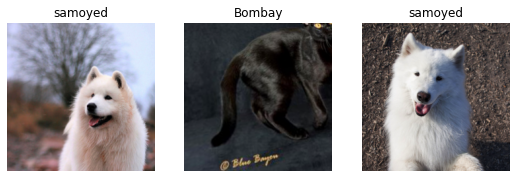

In [5]:
dls.show_batch(nrows = 1, ncols = 3)

In [6]:
petsBlock.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_104.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=476x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_104.jpg
    applying partial gives
      german_shorthaired
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(20)

Final sample: (PILImage mode=RGB size=476x500, TensorCategory(20))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': Fa

Já tendo o DataLoader criado, podemos já testar o modelo; é importante já começar os testes no início do desenvolvimento, para evitar que só descubra erros já visíveis depois de muito tempo.

In [7]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.533553,0.314453,0.102165,01:14


epoch,train_loss,valid_loss,error_rate,time
0,0.533985,0.274132,0.087280,01:16
1,0.342478,0.209391,0.069012,01:13


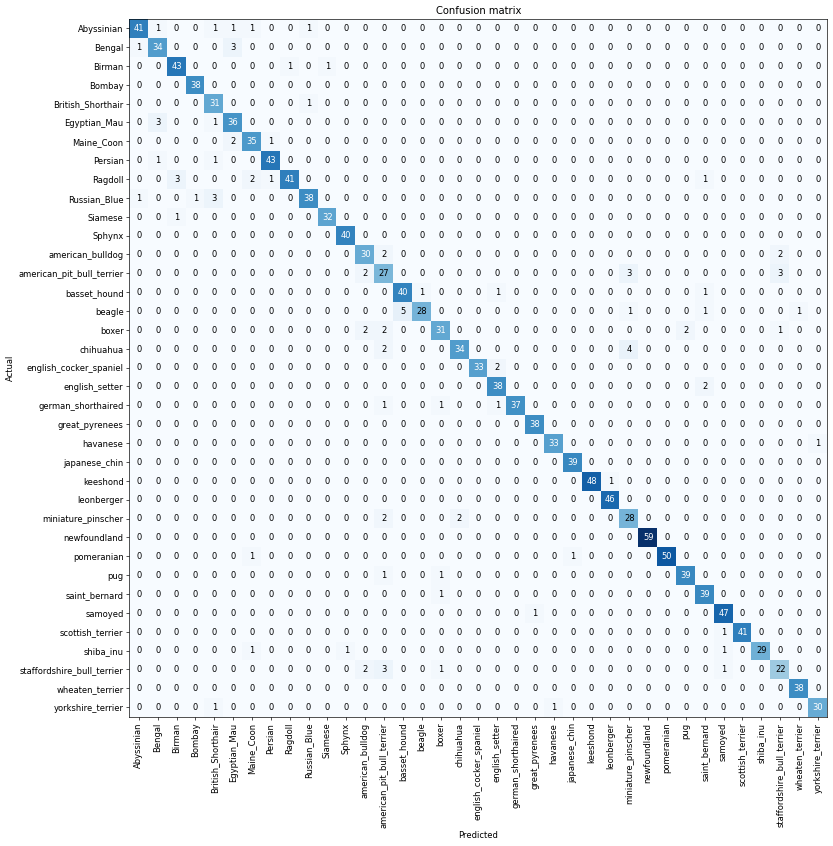

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(14,14), dpi=60)

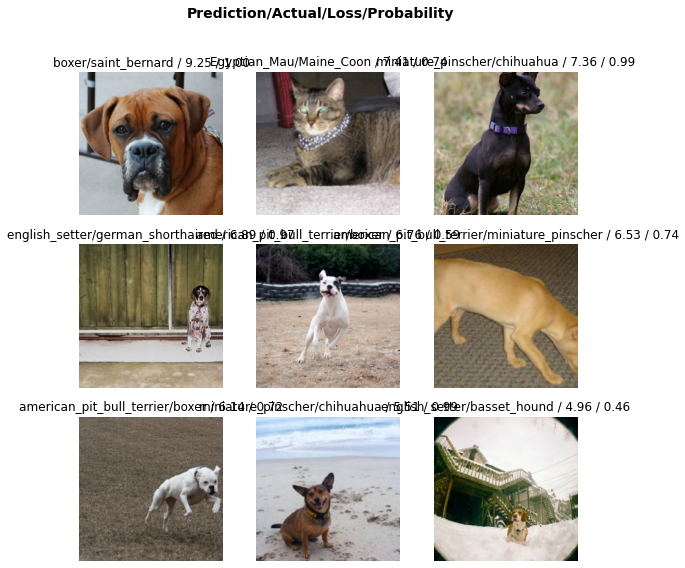

In [18]:
interp.plot_top_losses(9)

In [14]:
interp.most_confused(min_val=5)

[('beagle', 'basset_hound', 5)]

O resultado do treinamento acima nos mostra a métrica que pedimos, no caso o error_rate, e o loss médio dos itens de treinamento e validação. Porém, observe que não indicamos qual função utilizar para o cálculo do loss: nestes casos, o fastai vai tentar achar uma função padrão já apropriada para o tipo de dado que estamos trabalhando. No caso de dados de imagem, com um output categórico, o default seria a **Cross-Entropy Loss**.



Vamos agora fazer uma análise dos nossos dados atuais, para isso pegamos as variáveis dependentes (labels/targets, y) e independentes (todos os outros dados não incluindo as labels, x) de um batch do nosso DataLoader:

In [10]:
x, y = dls.one_batch()
# retorna as predictions e as targets
preds, _ = learn.get_preds(dl=[(x,y)]) # passamos a lista [(x,y)]
# como já temos targets, foi atribuida a var "_"  

preds[0]

TensorBase([2.2263e-06, 3.9477e-06, 1.9858e-06, 2.9218e-07, 7.3669e-07, 7.8694e-07, 9.9995e-01, 8.0110e-06, 2.8795e-05, 4.4713e-08, 2.3564e-09, 2.9940e-08, 8.8756e-09, 3.1061e-08, 1.3565e-08,
            1.9848e-08, 3.6913e-10, 1.4865e-07, 1.1506e-07, 7.2355e-08, 1.7308e-08, 2.5398e-07, 3.8382e-07, 1.6255e-07, 1.3204e-07, 2.9134e-07, 3.2777e-09, 4.1471e-07, 1.0436e-06, 1.0701e-08,
            5.4473e-08, 1.0233e-07, 5.5855e-08, 3.8878e-08, 3.2061e-09, 2.9439e-08, 1.1739e-06])

In [11]:
len(preds[0]), preds[0].sum()

(37, TensorBase(1.))